labels-map.csv not found. Please check the dataset structure.
Loaded 28182 samples with 33 unique classes.
Train: 16908 samples, Validation: 5637 samples, Test: 5637 samples
Training with ADAM optimizer and L2 regularization...
Epoch 0, Train Loss: 1.9488, Val Loss: 1.1812, Train Acc: 0.6927, Val Acc: 0.6601
Epoch 100, Train Loss: 0.1132, Val Loss: 0.1577, Train Acc: 0.9973, Val Acc: 0.9514

Rapport de classification (Test set):
              precision    recall  f1-score   support

          ya       0.98      0.99      0.99       171
         yab       0.92      0.93      0.92       171
        yach       0.98      0.97      0.97       171
         yad       0.95      0.96      0.96       171
        yadd       0.92      0.89      0.91       171
         yae       0.98      0.95      0.96       171
         yaf       0.97      0.98      0.98       171
         yag       0.96      0.99      0.97       171
        yagg       0.99      0.99      0.99       170
        yagh       0.99   

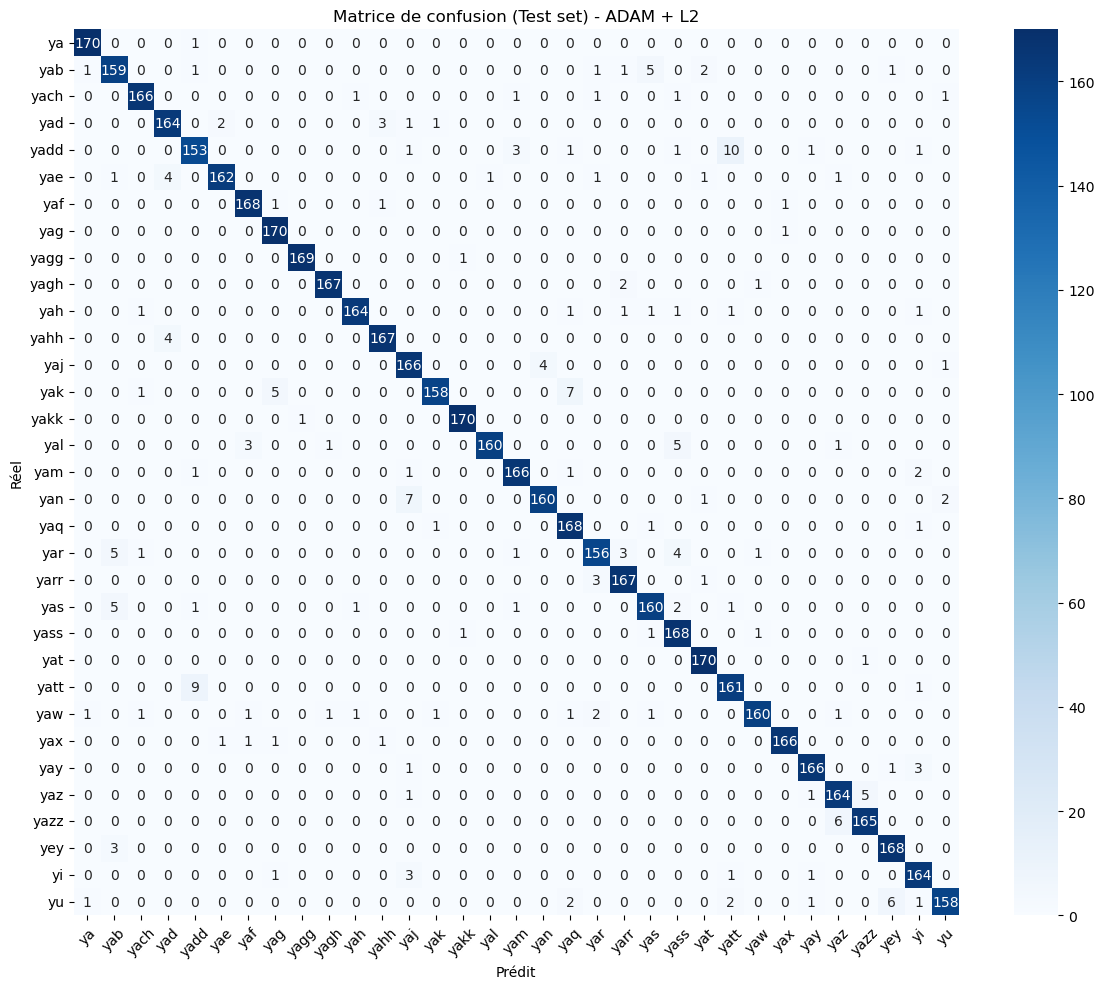

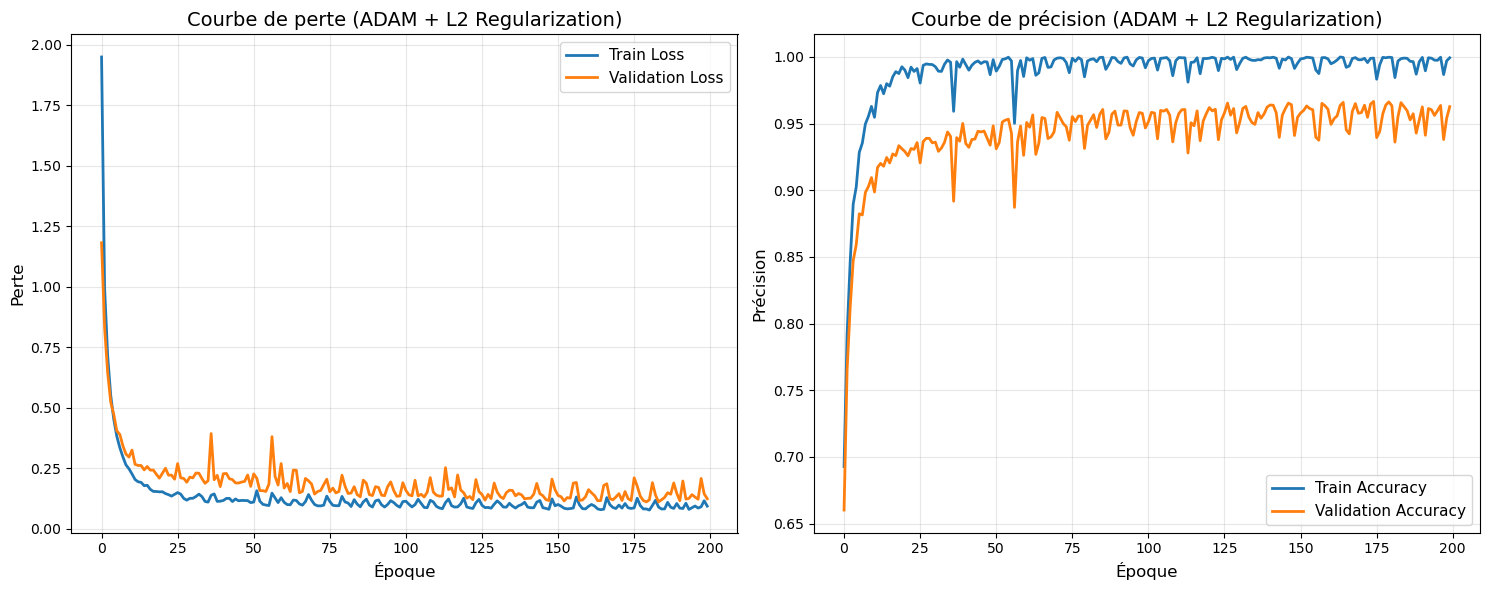


RÉSULTATS FINAUX (ADAM + L2 Regularization)
Précision finale - Train: 0.9994
Précision finale - Validation: 0.9627
Précision finale - Test: 0.9615
Paramètres du modèle:
  - Learning Rate: 0.001
  - L2 Lambda: 0.01
  - Architecture: [1024, 128, 64, 33]
  - ADAM Beta1: 0.9
  - ADAM Beta2: 0.999
Training completed with ADAM optimizer and L2 regularization!
Check the generated plots for detailed results.


In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Fonctions d'activation
def relu(x):
    """
    ReLU activation: max(0, x)
    """
    assert isinstance(x, np.ndarray), "Input to ReLU must be a numpy array"
    result = np.maximum(0, x)
    assert np.all(result >= 0), "ReLU output must be non-negative"
    return result

def relu_derivative(x):
    """
    Derivative of ReLU: 1 if x > 0, else 0
    """
    assert isinstance(x, np.ndarray), "Input to ReLU derivative must be a numpy array"
    result = (x > 0).astype(float)
    assert np.all((result == 0) | (result == 1)), "ReLU derivative must be 0 or 1"
    return result

def softmax(x):
    """
    Softmax activation: exp(x) / sum(exp(x))
    """
    assert isinstance(x, np.ndarray), "Input to softmax must be a numpy array"
    # Numerical stability: subtract max to prevent overflow
    x_shifted = x - np.max(x, axis=1, keepdims=True)
    exp_x = np.exp(x_shifted)
    result = exp_x / np.sum(exp_x, axis=1, keepdims=True)
    assert np.all((result >= 0) & (result <= 1)), "Softmax output must be in [0, 1]"
    assert np.allclose(np.sum(result, axis=1), 1), "Softmax output must sum to 1 per sample"
    return result

# Classe MultiClassNeuralNetwork avec ADAM et L2
class MultiClassNeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.001, l2_lambda=0.001,
                 beta1=0.9, beta2=0.999, epsilon=1e-8):
        """
        Initialize the neural network with ADAM optimizer and L2 regularization.

        Parameters:
        - layer_sizes: List of integers [input_size, hidden1_size, ..., output_size]
        - learning_rate: Learning rate for ADAM optimizer (default: 0.001)
        - l2_lambda: L2 regularization coefficient (default: 0.001)
        - beta1: ADAM momentum parameter (default: 0.9)
        - beta2: ADAM RMSprop parameter (default: 0.999)
        - epsilon: Small constant for numerical stability (default: 1e-8)
        """
        assert isinstance(layer_sizes, list) and len(layer_sizes) >= 2, "layer_sizes must be a list with at least 2 elements"
        assert all(isinstance(size, int) and size > 0 for size in layer_sizes), "All layer sizes must be positive integers"
        assert isinstance(learning_rate, (int, float)) and learning_rate > 0, "Learning rate must be a positive number"
        assert isinstance(l2_lambda, (int, float)) and l2_lambda >= 0, "L2 lambda must be non-negative"

        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0  # Time step for ADAM

        self.weights = []
        self.biases = []

        # ADAM optimizer parameters
        self.m_weights = []  # First moment estimates for weights
        self.v_weights = []  # Second moment estimates for weights
        self.m_biases = []   # First moment estimates for biases
        self.v_biases = []   # Second moment estimates for biases

        # Initialisation des poids et biais avec Xavier/Glorot initialization
        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            # Xavier initialization for better gradient flow
            limit = np.sqrt(6.0 / (layer_sizes[i] + layer_sizes[i+1]))
            w = np.random.uniform(-limit, limit, (layer_sizes[i], layer_sizes[i+1]))
            b = np.zeros((1, layer_sizes[i+1]))

            assert w.shape == (layer_sizes[i], layer_sizes[i+1]), f"Weight matrix {i+1} has incorrect shape"
            assert b.shape == (1, layer_sizes[i+1]), f"Bias vector {i+1} has incorrect shape"

            self.weights.append(w)
            self.biases.append(b)

            # Initialize ADAM parameters
            self.m_weights.append(np.zeros_like(w))
            self.v_weights.append(np.zeros_like(w))
            self.m_biases.append(np.zeros_like(b))
            self.v_biases.append(np.zeros_like(b))

    def forward(self, X):
        """
        Forward propagation: Z^{[l]} = A^{[l-1]} W^{[l]} + b^{[l]}, A^{[l]} = g(Z^{[l]})
        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        self.activations = [X]
        self.z_values = []

        for i in range(len(self.weights) - 1):
            z = self.activations[i] @ self.weights[i] + self.biases[i]
            assert z.shape == (X.shape[0], self.layer_sizes[i+1]), f"Z^{[{i+1}]} has incorrect shape"
            self.z_values.append(z)
            self.activations.append(relu(z))

        z = self.activations[-1] @ self.weights[-1] + self.biases[-1]
        assert z.shape == (X.shape[0], self.layer_sizes[-1]), "Output Z has incorrect shape"
        self.z_values.append(z)
        output = softmax(z)
        assert output.shape == (X.shape[0], self.layer_sizes[-1]), "Output A has incorrect shape"
        self.activations.append(output)

        return self.activations[-1]

    def compute_loss(self, y_true, y_pred):
        """
        Categorical Cross-Entropy with L2 regularization:
        J = -1/m * sum(y_true * log(y_pred)) + lambda/2m * sum(W^2)
        """
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to loss must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"

        m = y_true.shape[0]

        # Cross-entropy loss
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        cross_entropy_loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

        # L2 regularization term
        l2_loss = 0
        for w in self.weights:
            l2_loss += np.sum(w ** 2)
        l2_loss = (self.l2_lambda / (2 * m)) * l2_loss

        total_loss = cross_entropy_loss + l2_loss
        assert not np.isnan(total_loss), "Loss computation resulted in NaN"
        return total_loss

    def compute_accuracy(self, y_true, y_pred):
        """
        Compute accuracy: proportion of correct predictions
        """
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to accuracy must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"

        predictions = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y_true, axis=1)
        accuracy = np.mean(predictions == true_labels)
        assert 0 <= accuracy <= 1, "Accuracy must be between 0 and 1"
        return accuracy

    def backward(self, X, y, outputs):
        """
        Backpropagation with ADAM optimizer: compute and apply gradients
        """
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(outputs, np.ndarray), "Inputs to backward must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape == outputs.shape, "y and outputs must have the same shape"

        m = X.shape[0]
        self.t += 1  # Increment time step for ADAM

        # Initialize gradient arrays
        d_weights = [np.zeros_like(w) for w in self.weights]
        d_biases = [np.zeros_like(b) for b in self.biases]

        # Backpropagation
        dZ = outputs - y  # Gradient pour softmax + cross-entropy
        assert dZ.shape == outputs.shape, "dZ for output layer has incorrect shape"

        # Output layer gradients with L2 regularization
        d_weights[-1] = (self.activations[-2].T @ dZ) / m + (self.l2_lambda / m) * self.weights[-1]
        d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m

        # Hidden layers gradients
        for i in range(len(self.weights) - 2, -1, -1):
            dZ = (dZ @ self.weights[i+1].T) * relu_derivative(self.z_values[i])
            assert dZ.shape == (X.shape[0], self.layer_sizes[i+1]), f"dZ^{[{i+1}]} has incorrect shape"

            # Add L2 regularization to weight gradients
            d_weights[i] = (self.activations[i].T @ dZ) / m + (self.l2_lambda / m) * self.weights[i]
            d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m

        # ADAM optimizer update
        self._adam_update(d_weights, d_biases)

    def _adam_update(self, d_weights, d_biases):
        """
        ADAM optimizer parameter update
        """
        # Bias correction terms
        bias_correction1 = 1 - self.beta1 ** self.t
        bias_correction2 = 1 - self.beta2 ** self.t

        for i in range(len(self.weights)):
            # Update biased first moment estimate for weights
            self.m_weights[i] = self.beta1 * self.m_weights[i] + (1 - self.beta1) * d_weights[i]
            # Update biased second raw moment estimate for weights
            self.v_weights[i] = self.beta2 * self.v_weights[i] + (1 - self.beta2) * (d_weights[i] ** 2)

            # Compute bias-corrected first moment estimate for weights
            m_hat_w = self.m_weights[i] / bias_correction1
            # Compute bias-corrected second raw moment estimate for weights
            v_hat_w = self.v_weights[i] / bias_correction2

            # Update weights
            self.weights[i] -= self.learning_rate * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)

            # Update biased first moment estimate for biases
            self.m_biases[i] = self.beta1 * self.m_biases[i] + (1 - self.beta1) * d_biases[i]
            # Update biased second raw moment estimate for biases
            self.v_biases[i] = self.beta2 * self.v_biases[i] + (1 - self.beta2) * (d_biases[i] ** 2)

            # Compute bias-corrected first moment estimate for biases
            m_hat_b = self.m_biases[i] / bias_correction1
            # Compute bias-corrected second raw moment estimate for biases
            v_hat_b = self.v_biases[i] / bias_correction2

            # Update biases
            self.biases[i] -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)

    def train(self, X, y, X_val, y_val, epochs, batch_size):
        """
        Train the neural network using mini-batch SGD with ADAM optimizer, with validation
        """
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "X and y must be numpy arrays"
        assert isinstance(X_val, np.ndarray) and isinstance(y_val, np.ndarray), "X_val and y_val must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape[1] == self.layer_sizes[-1], f"Output dimension ({y.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert X_val.shape[1] == self.layer_sizes[0], f"Validation input dimension ({X_val.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y_val.shape[1] == self.layer_sizes[-1], f"Validation output dimension ({y_val.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert isinstance(epochs, int) and epochs > 0, "Epochs must be a positive integer"
        assert isinstance(batch_size, int) and batch_size > 0, "Batch size must be a positive integer"

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(epochs):
            # Shuffle training data
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            epoch_loss = 0
            num_batches = 0

            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]

                outputs = self.forward(X_batch)
                batch_loss = self.compute_loss(y_batch, outputs)
                epoch_loss += batch_loss
                num_batches += 1

                self.backward(X_batch, y_batch, outputs)

            # Calculate metrics
            avg_train_loss = epoch_loss / num_batches
            train_pred = self.forward(X)
            train_accuracy = self.compute_accuracy(y, train_pred)
            val_pred = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_pred)
            val_accuracy = self.compute_accuracy(y_val, val_pred)

            train_losses.append(avg_train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                      f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        """
        Predict class labels
        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        outputs = self.forward(X)
        predictions = np.argmax(outputs, axis=1)
        assert predictions.shape == (X.shape[0],), "Predictions have incorrect shape"
        return predictions

# Définir le chemin vers le dossier décompressé
data_dir = os.path.join(os.getcwd(), 'amhcd-data-64/tifinagh-images/')
#print(data_dir)
current_working_directory = os.getcwd()
#print(current_working_directory)

# Charger le fichier CSV contenant les étiquettes
try:
    labels_df = pd.read_csv(os.path.join(data_dir, 'amhcd-data-64/labels-map.csv'))
    assert 'image_path' in labels_df.columns and 'label' in labels_df.columns, "CSV must contain 'image_path' and 'label' columns"
except FileNotFoundError:
    print("labels-map.csv not found. Please check the dataset structure.")
    # Alternative: construire un DataFrame à partir des dossiers
    image_paths = []
    labels = []
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                image_paths.append(os.path.join(label_path, img_name))
                labels.append(label_dir)
    labels_df = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Vérifier le DataFrame
assert not labels_df.empty, "No data loaded. Check dataset files."
print(f"Loaded {len(labels_df)} samples with {labels_df['label'].nunique()} unique classes.")

# Encoder les étiquettes
label_encoder = LabelEncoder()
labels_df['label_encoded'] = label_encoder.fit_transform(labels_df['label'])
num_classes = len(label_encoder.classes_)

# Fonction pour charger et prétraiter une image
def load_and_preprocess_image(image_path, target_size=(32, 32)):
    """
    Load and preprocess an image: convert to grayscale, resize, normalize
    """
    assert os.path.exists(image_path), f"Image not found: {image_path}"
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    assert img is not None, f"Failed to load image: {image_path}"
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0  # Normalisation
    return img.flatten()  # Aplatir pour le réseau de neurones

# Charger toutes les images
X = np.array([load_and_preprocess_image(os.path.join(data_dir, path)) for path in labels_df['image_path']])
y = labels_df['label_encoded'].values

# Vérifier les dimensions
assert X.shape[0] == y.shape[0], "Mismatch between number of images and labels"
assert X.shape[1] == 32 * 32, f"Expected flattened image size of {32*32}, got {X.shape[1]}"

# Diviser en ensembles d'entraînement, validation et test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Convertir explicitement en NumPy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == X.shape[0], "Train-val-test split sizes must sum to total samples"

print(f"Train: {X_train.shape[0]} samples, Validation: {X_val.shape[0]} samples, Test: {X_test.shape[0]} samples")

# Encoder les étiquettes en one-hot pour la classification multiclasse
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train_one_hot = np.array(one_hot_encoder.fit_transform(y_train.reshape(-1, 1)))
y_val_one_hot = np.array(one_hot_encoder.transform(y_val.reshape(-1, 1)))
y_test_one_hot = np.array(one_hot_encoder.transform(y_test.reshape(-1, 1)))

# Vérifier que les tableaux one-hot sont des NumPy arrays
assert isinstance(y_train_one_hot, np.ndarray), "y_train_one_hot must be a numpy array"
assert isinstance(y_val_one_hot, np.ndarray), "y_val_one_hot must be a numpy array"
assert isinstance(y_test_one_hot, np.ndarray), "y_test_one_hot must be a numpy array"

# Créer et entraîner le modèle avec ADAM et L2 regularization
layer_sizes = [X_train.shape[1], 128, 64, num_classes]  # Increased hidden layer sizes
nn = MultiClassNeuralNetwork(
    layer_sizes=layer_sizes,
    learning_rate=0.001,    # ADAM default learning rate
    l2_lambda=0.01,         # L2 regularization strength
    beta1=0.9,              # ADAM momentum parameter
    beta2=0.999,            # ADAM RMSprop parameter
    epsilon=1e-8            # ADAM numerical stability
)

print("Training with ADAM optimizer and L2 regularization...")
train_losses, val_losses, train_accuracies, val_accuracies = nn.train(
    X_train, y_train_one_hot, X_val, y_val_one_hot, epochs=200, batch_size=64
)

# Prédictions et évaluation
y_pred = nn.predict(X_test)
print("\nRapport de classification (Test set):")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Matrice de confusion (Test set) - ADAM + L2')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_adam_l2.png', dpi=300, bbox_inches='tight')
plt.show()

# Courbes de perte et d'accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Courbe de perte
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(val_losses, label='Validation Loss', linewidth=2)
ax1.set_title('Courbe de perte (ADAM + L2 Regularization)', fontsize=14)
ax1.set_xlabel('Époque', fontsize=12)
ax1.set_ylabel('Perte', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Courbe d'accuracy
ax2.plot(train_accuracies, label='Train Accuracy', linewidth=2)
ax2.plot(val_accuracies, label='Validation Accuracy', linewidth=2)
ax2.set_title('Courbe de précision (ADAM + L2 Regularization)', fontsize=14)
ax2.set_xlabel('Époque', fontsize=12)
ax2.set_ylabel('Précision', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig('loss_accuracy_plot_adam_l2.png', dpi=300, bbox_inches='tight')
plt.show()

# Print final metrics
final_train_acc = train_accuracies[-1]
final_val_acc = val_accuracies[-1]
final_test_acc = nn.compute_accuracy(y_test_one_hot, nn.forward(X_test))

print(f"\n{'='*60}")
print("RÉSULTATS FINAUX (ADAM + L2 Regularization)")
print(f"{'='*60}")
print(f"Précision finale - Train: {final_train_acc:.4f}")
print(f"Précision finale - Validation: {final_val_acc:.4f}")
print(f"Précision finale - Test: {final_test_acc:.4f}")
print(f"Paramètres du modèle:")
print(f"  - Learning Rate: {nn.learning_rate}")
print(f"  - L2 Lambda: {nn.l2_lambda}")
print(f"  - Architecture: {layer_sizes}")
print(f"  - ADAM Beta1: {nn.beta1}")
print(f"  - ADAM Beta2: {nn.beta2}")
print(f"{'='*60}")

print("Training completed with ADAM optimizer and L2 regularization!")
print("Check the generated plots for detailed results.")